# Clustering Analysis 

In [4]:
# import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.metrics import normalized_mutual_info_score as nmi

In [5]:
# import data from 01_preprocessing jupyter notebook
GTEx_data = pd.read_pickle("GTEx_data_input.pkl")
GTEx_labels = pd.read_pickle("GTEx_labels.pkl")

## PCA and Data Exploration

PCA plot inspired by this [medium article](https://medium.com/leukemiaairesearch/clustering-techniques-with-gene-expression-data-4b35a04f87d5)

In [59]:
from sklearn.decomposition import PCA
# reduce GTEx data to a PCA of 50 dimensions
pca = PCA(n_components=50)
X = pca.fit(GTEx_data).transform(GTEx_data)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(GTEx_labels)
y_lan = le.transform(GTEx_labels)

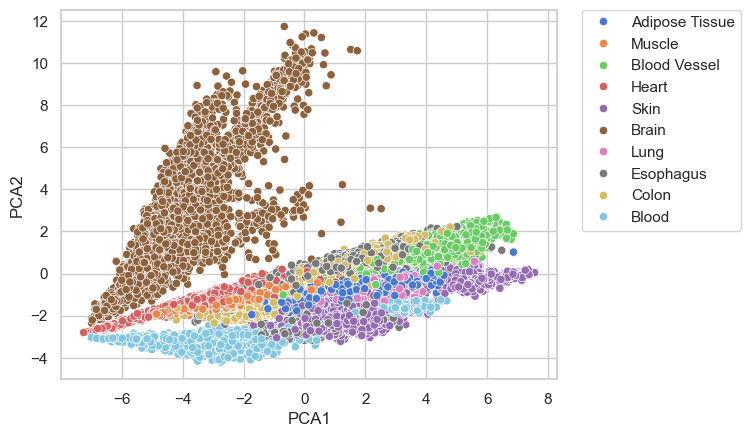

In [58]:
pca_df = pd.DataFrame({
    "PCA1": X[:, 0],
    "PCA2": X[:, 1],
    "Tissue": GTEx_labels,
    "label": y_lan
})
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Tissue", data=pca_df, alpha = 1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Interestingly, the brain appears to well separate from the other tissue types. Also interestingly, the skin tissue appears to be similar to both blood and lung. Esophagus and colon are right on top of each other as well. 

## K-means Analysis and Evaluation

### Selecting K for K-means
Obviously we'd expect there to be 10 clusters for each of the sample types, but does the data show this? 

In [6]:
# import methods
from sklearn import cluster
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari

In [7]:
# convert data into numpy array
GTEx = GTEx_data.to_numpy()

#### K Selection Results 

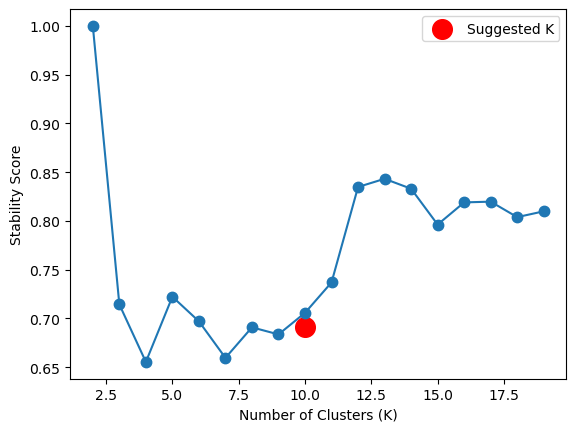

In [9]:

# consensus method
Ks = range(2, 20)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(GTEx))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

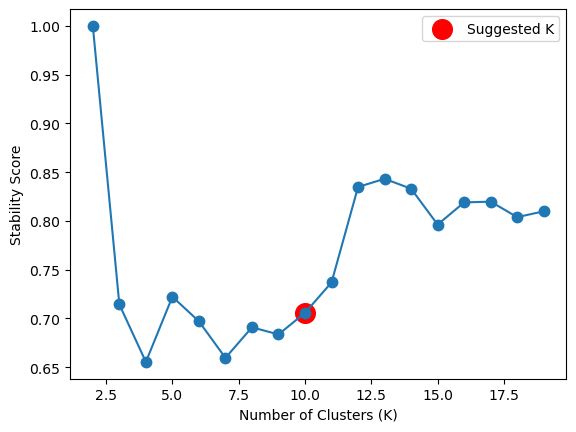

In [11]:
plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.scatter(
    [10],
    [stability_scores[8]],
    s=200,
    color="red",
    label="Suggested K",
)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

In [8]:
# elbow method
Ks, objs = range(2, 20), []
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    model.fit(GTEx)
    objs.append(-model.score(GTEx) / GTEx.shape[0])

KeyboardInterrupt: 

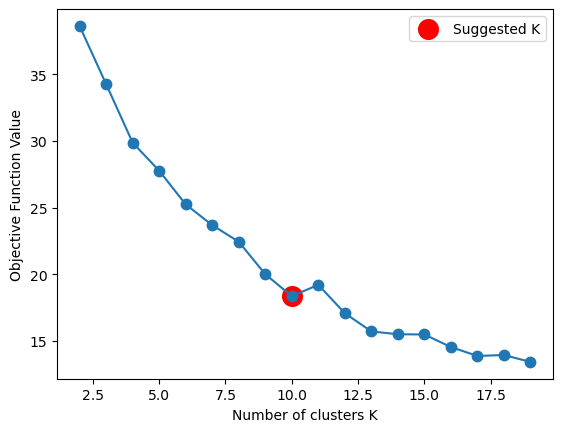

In [13]:
plt.plot(Ks, objs, ".-", markersize=15)
plt.scatter([10], [objs[8]], s=200, color="red", label="Suggested K")
plt.xlabel("Number of clusters K")
plt.ylabel("Objective Function Value")
plt.legend()

### Internal Method Results

Without looking at the true labels, we'll perform internal methods to assess clustering quality. 

In [13]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(GTEx)
    perf_s[k] = silhouette_score(GTEx, part)
    perf_c[k] = calinski_harabasz_score(GTEx, part)
    perf_d[k] = davies_bouldin_score(GTEx, part)

In [14]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=Ks,
)
display(_tmp)

,Silhouette,CH,DB
2,0.097861,1214.852161,1.849548
3,0.211818,2576.540635,1.625949
4,0.186076,2038.596526,1.820199
5,0.245607,2398.724791,1.484117
6,0.233382,2273.309067,1.695161
7,0.228192,2205.168321,1.579660
8,0.237445,2155.246618,1.493496
9,0.245285,2127.968209,1.362493
10,0.238721,2115.893730,1.456797
11,0.236689,2047.125352,1.449193


In [15]:
# how well do the metrics correlate with each other? 
_tmp.corr()

,Silhouette,CH,DB
Silhouette,1.000000,0.427199,-0.842679
CH,0.427199,1.000000,-0.122675
DB,-0.842679,-0.122675,1.000000


Silhouette is around 0.2 for most of the K's tested. This is fairly close to 0 and may indicate that the clusters overlap with one another. CH poorly correlates with the other two metrics. Likely because it peaks at 3 clusters while the others have max/min after 10 clusters (18 for silhouette and 13 for DB). 

### External Methods Results

In [9]:
# Prepare labels for testing ari/nmi external methods
unique_tissues = GTEx_labels.unique()
unique_tissues
# generate dictionary to convert tissue names to integers
tissue_to_int = {value: idx for idx, value in enumerate(unique_tissues)}
tissue_to_int
# convert GTEx_labels to integers
GTEx_labels_int = GTEx_labels.map(tissue_to_int)
GTEx_labels_int.head()

SAMPID
GTEX-1117F-0226-SM-5GZZ7    0
GTEX-1117F-0426-SM-5EGHI    1
GTEX-1117F-0526-SM-5EGHJ    2
GTEX-1117F-0626-SM-5N9CS    2
GTEX-1117F-0726-SM-5GIEN    3
Name: SMTS, dtype: int64

In [ ]:
perf_ari = {}
perf_nmi = {}
perf_fmi = {}
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(GTEx)
    perf_ari[k] = ari(part, GTEx_labels_int)
    perf_nmi[k] = nmi(part, GTEx_labels_int)
    perf_fmi[k] = metrics.fowlkes_mallows_score(GTEx_labels_int, part)

In [118]:
ext_kmeans = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
        "fmi": perf_fmi,
    },
    index=Ks,
)
display(ext_kmeans)

,ari,nmi,fmi
2,0.003908,0.033128,0.349621
3,0.003873,0.033224,0.349550
4,0.003839,0.033321,0.349478
5,0.003804,0.033417,0.349407
6,0.006153,0.099022,0.338184
7,0.006161,0.099138,0.338165
8,0.006169,0.099254,0.338147
9,0.006192,0.099401,0.338146
10,0.006115,0.099534,0.337996
11,0.006135,0.099672,0.337991


In [ ]:
# what is the correlation between these metrics?
ext_kmeans.corr()

,ari,nmi,fmi
ari,1.000000,0.987265,0.973954
nmi,0.987265,1.000000,0.943554
fmi,0.973954,0.943554,1.000000


Interestingly, the best K for K-means doesn't appear to be 10 like I would assume. Instead, both methods had differing best values. The elbow method seems to prefer 13 while the stability index prefers 2. So the internal methods appear to have a potential consensus around 13. When you look at external methods, the ari/nmi scores are highest at 15 clusters. 

### PCA Representation of Clusters

In [61]:
# use 15 clusters based on ari/nmi scores 
model = cluster.KMeans(n_clusters=15, n_init="auto")
part = model.fit_predict(GTEx)
model.labels_.shape

(12385,)

In [89]:
pca_df["kmeans_clusters"] = model.labels_

pca_df.head()

pca_df["kmeans_clusters"] = pca_df["kmeans_clusters"].astype("category")
# set as categorical variable
pca_df.value_counts("kmeans_clusters")

result = pca_df.groupby('kmeans_clusters')['Tissue'].apply(set).reset_index()
result.columns = ['kmeans_clusters', 'unique_Tissue_values']
result


/var/folders/m5/blr39n_j1rjb3ljhqqkft6bm0000gn/T/ipykernel_32056/1562505770.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = pca_df.groupby('kmeans_clusters')['Tissue'].apply(set).reset_index()


,kmeans_clusters,unique_Tissue_values
0,0,"{Muscle, Blood Vessel, Skin}"
1,1,"{Esophagus, Colon, Blood Vessel}"
2,2,"{Adipose Tissue, Heart, Esophagus, Colon, Bloo..."
3,3,"{Adipose Tissue, Skin}"
4,4,{Blood}
5,5,"{Adipose Tissue, Blood Vessel, Heart, Lung, Es..."
6,6,"{Esophagus, Adipose Tissue, Blood Vessel}"
7,7,{Skin}
8,8,{Brain}
9,9,"{Esophagus, Colon}"


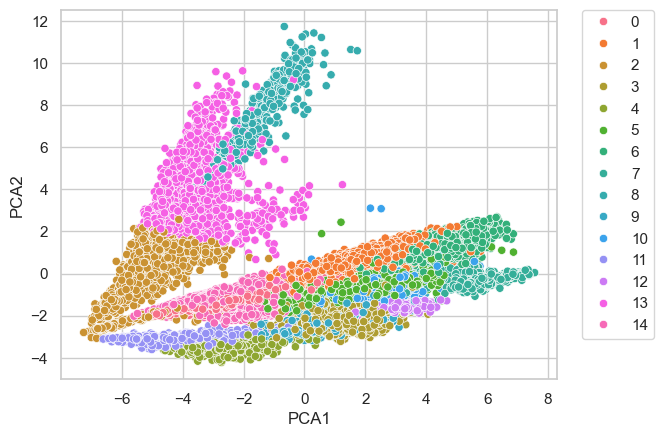

In [70]:

ax = sns.scatterplot(x="PCA1", y="PCA2", hue="kmeans_clusters", data=pca_df, alpha = 1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Decision Tree Interpretation

In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [90]:

clt = DecisionTreeClassifier(max_depth=4, random_state=0).fit(GTEx, part)

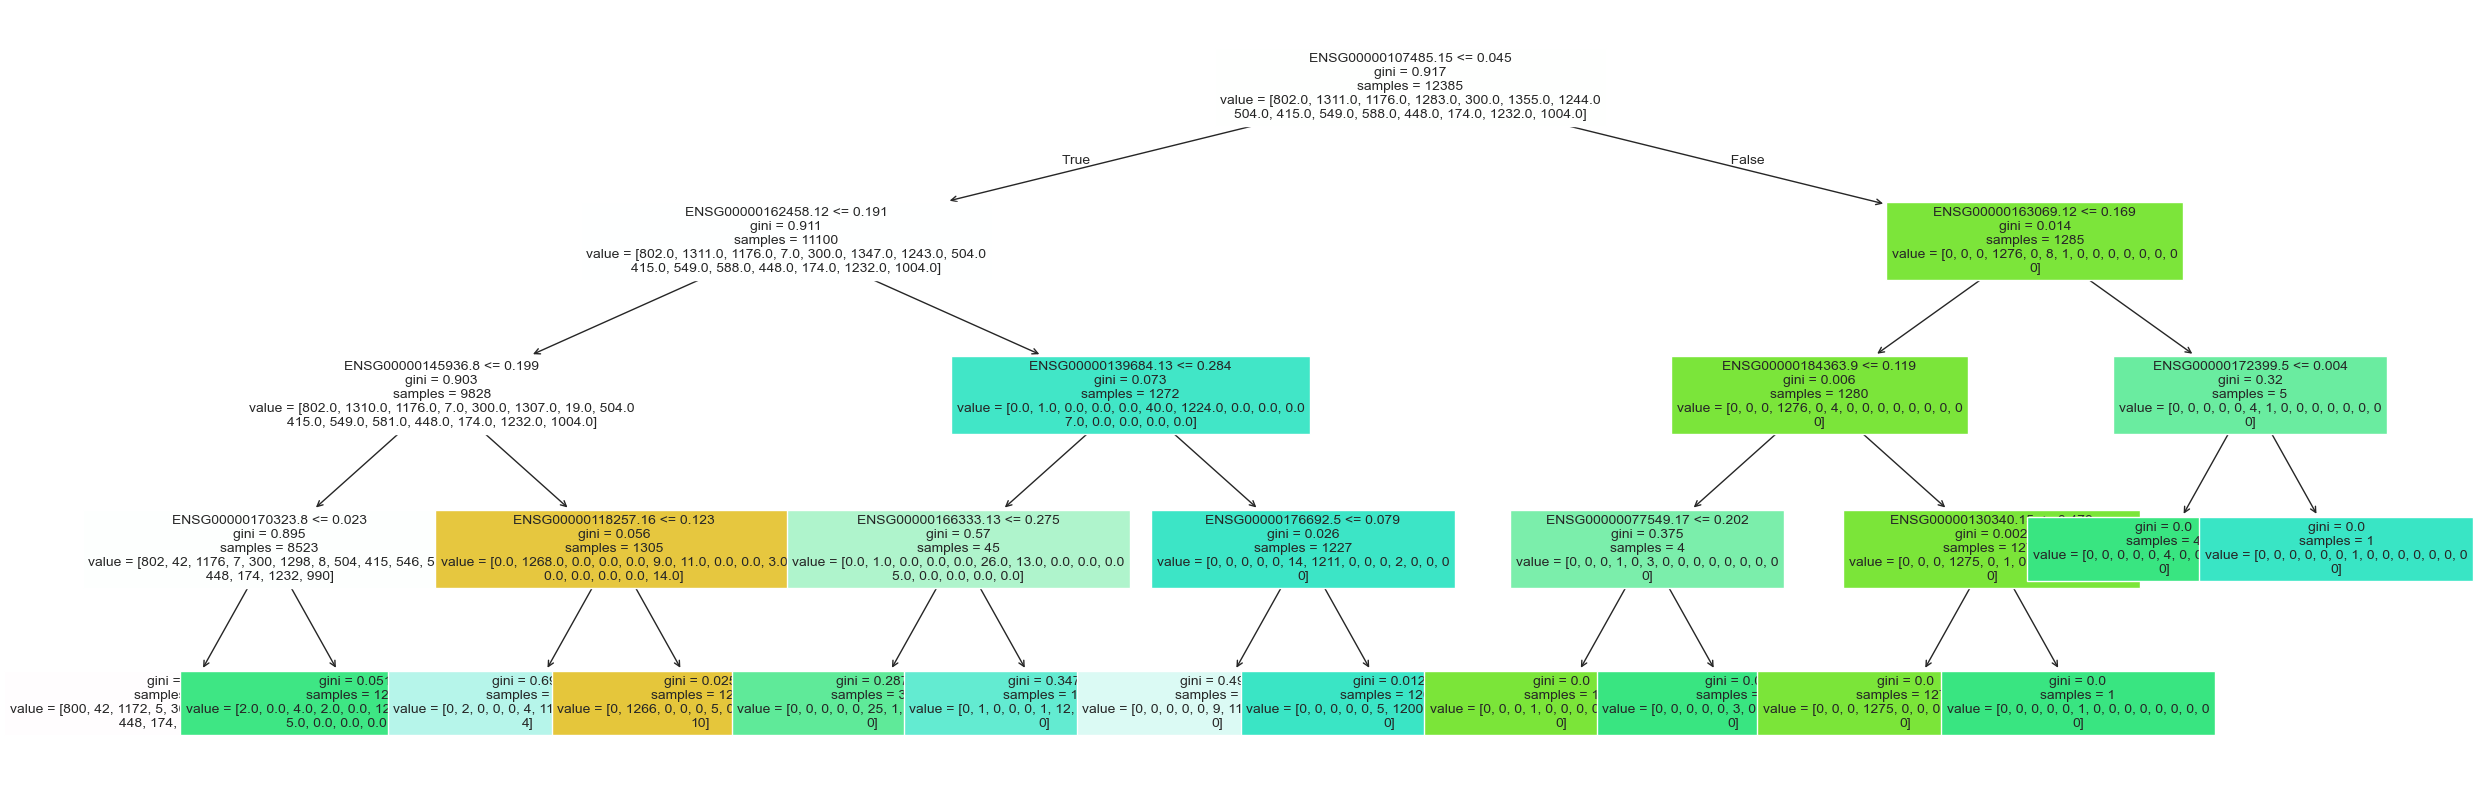

In [91]:
fig = plt.figure(figsize=(30, 10))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=GTEx_data.columns.tolist(),
)

In [92]:
# export tree as text format
from sklearn.tree import export_text
rules = export_text(clt, feature_names=GTEx_data.columns.tolist())

print(rules)

|--- ENSG00000107485.15 <= 0.05
|   |--- ENSG00000162458.12 <= 0.19
|   |   |--- ENSG00000145936.8 <= 0.20
|   |   |   |--- ENSG00000170323.8 <= 0.02
|   |   |   |   |--- class: 13
|   |   |   |--- ENSG00000170323.8 >  0.02
|   |   |   |   |--- class: 5
|   |   |--- ENSG00000145936.8 >  0.20
|   |   |   |--- ENSG00000118257.16 <= 0.12
|   |   |   |   |--- class: 6
|   |   |   |--- ENSG00000118257.16 >  0.12
|   |   |   |   |--- class: 1
|   |--- ENSG00000162458.12 >  0.19
|   |   |--- ENSG00000139684.13 <= 0.28
|   |   |   |--- ENSG00000166333.13 <= 0.27
|   |   |   |   |--- class: 5
|   |   |   |--- ENSG00000166333.13 >  0.27
|   |   |   |   |--- class: 6
|   |   |--- ENSG00000139684.13 >  0.28
|   |   |   |--- ENSG00000176692.5 <= 0.08
|   |   |   |   |--- class: 6
|   |   |   |--- ENSG00000176692.5 >  0.08
|   |   |   |   |--- class: 6
|--- ENSG00000107485.15 >  0.05
|   |--- ENSG00000163069.12 <= 0.17
|   |   |--- ENSG00000184363.9 <= 0.12
|   |   |   |--- ENSG00000077549.17 <= 0.2

## Hierarchial Clustering

Originally, I tried to run hierarchial clustering on the direct data, without any dimensionality reduction. This led to many issues. Hierarchial clustering is very time complex. So, it took over 208 minutes to compute 3 external metrics following the code I used with k-means (that took 5 minutes). Further, the results were far worse than the k-means methods. ARI was a max of 0.003 while it was 0.5 for the first run of hierarchial clustering. I found a resource that mentioned dimensionality reduction (for example PCAs) is compatitble with hierarchial clustering and may improve results. 

### External Metrics 

#### Using Ward

In [94]:
perf_ari = {}
perf_nmi = {}
perf_fmi = {}
for k in Ks:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
    part = model.fit_predict(X) # predict using PCA instead of GTEx
    perf_ari[k] = ari(part, GTEx_labels_int)
    perf_nmi[k] = nmi(part, GTEx_labels_int)
    perf_fmi[k] = metrics.fowlkes_mallows_score(GTEx_labels_int, part)

In [95]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
        "fmi": perf_fmi,
    },
    index=Ks,
)
display(_tmp)

,ari,nmi,fmi
2,0.220681,0.412266,0.473976
3,0.273118,0.471005,0.476599
4,0.238876,0.496772,0.413987
5,0.290735,0.562592,0.443308
6,0.337729,0.621297,0.470815
7,0.380358,0.671785,0.496639
8,0.485605,0.727162,0.562961
9,0.453264,0.714994,0.532447
10,0.543647,0.761364,0.599486
11,0.578667,0.777302,0.628099


In [96]:
_tmp.corr()

,ari,nmi,fmi
ari,1.000000,0.976053,0.976834
nmi,0.976053,1.000000,0.912558
fmi,0.976834,0.912558,1.000000


#### Using Single

In [ ]:
perf_ari = {}
perf_nmi = {}
perf_fmi = {}
for k in Ks:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
    part = model.fit_predict(X) # predict using PCA instead of GTEx
    perf_ari[k] = ari(part, GTEx_labels_int)
    perf_nmi[k] = nmi(part, GTEx_labels_int)
    perf_fmi[k] = metrics.fowlkes_mallows_score(GTEx_labels_int, part)

In [98]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
        "fmi": perf_fmi,
    },
    index=Ks,
)
display(_tmp)

,ari,nmi,fmi
2,0.003908,0.033128,0.349621
3,0.003873,0.033224,0.349550
4,0.003839,0.033321,0.349478
5,0.003804,0.033417,0.349407
6,0.006153,0.099022,0.338184
7,0.006161,0.099138,0.338165
8,0.006169,0.099254,0.338147
9,0.006192,0.099401,0.338146
10,0.006115,0.099534,0.337996
11,0.006135,0.099672,0.337991


In [99]:
_tmp.corr()

,ari,nmi,fmi
ari,1.000000,0.999543,-0.999249
nmi,0.999543,1.000000,-0.999960
fmi,-0.999249,-0.999960,1.000000


#### Complete linkage

In [100]:
perf_ari = {}
perf_nmi = {}
perf_fmi = {}
for k in Ks:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
    part = model.fit_predict(X) # predict using PCA instead of GTEx
    perf_ari[k] = ari(part, GTEx_labels_int)
    perf_nmi[k] = nmi(part, GTEx_labels_int)
    perf_fmi[k] = metrics.fowlkes_mallows_score(GTEx_labels_int, part)

In [101]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
        "fmi": perf_fmi,
    },
    index=Ks,
)
display(_tmp)

,ari,nmi,fmi
2,0.003908,0.033128,0.349621
3,0.003873,0.033224,0.349550
4,0.003839,0.033321,0.349478
5,0.003804,0.033417,0.349407
6,0.006153,0.099022,0.338184
7,0.006161,0.099138,0.338165
8,0.006169,0.099254,0.338147
9,0.006192,0.099401,0.338146
10,0.006115,0.099534,0.337996
11,0.006135,0.099672,0.337991


Interestingly, single and complete performed way worse than ward. We'll use ward for the rest of the analyses. 

### Internal Metrics


In [103]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in Ks:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [115]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=Ks,
)
display(_tmp)

,Silhouette,CH,DB
2,0.232718,3463.139231,1.788028
3,0.228418,2884.363470,1.522790
4,0.247949,2912.023129,1.404642
5,0.275612,2773.965935,1.353174
6,0.290589,2765.505753,1.306730
7,0.296608,2713.878989,1.245191
8,0.281164,2746.109016,1.299656
9,0.290653,2786.409988,1.243944
10,0.304259,2830.375640,1.225526
11,0.309061,2811.726545,1.218881


In [117]:
_tmp.corr()

,Silhouette,CH,DB
Silhouette,1.000000,-0.545652,-0.938482
CH,-0.545652,1.000000,0.768918
DB,-0.938482,0.768918,1.000000


### PCA Visualization of Clusters

In [109]:
# use 14 clusters based on ari/fmi scores 
model = cluster.AgglomerativeClustering(n_clusters=14, linkage="ward")
part = model.fit_predict(X) # predict using PCA instead of GTEx
model.labels_.shape

(12385,)

In [110]:
pca_df["h_clusters"] = model.labels_

pca_df.head()

pca_df["h_clusters"] = pca_df["h_clusters"].astype("category")
# set as categorical variable
pca_df.value_counts("h_clusters")

result = pca_df.groupby('h_clusters')['Tissue'].apply(set).reset_index()
result.columns = ['h_clusters', 'unique_Tissue_values_h']
result

/var/folders/m5/blr39n_j1rjb3ljhqqkft6bm0000gn/T/ipykernel_32056/1390754604.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = pca_df.groupby('h_clusters')['Tissue'].apply(set).reset_index()


,h_clusters,unique_Tissue_values_h
0,0,{Blood}
1,1,"{Lung, Heart, Blood Vessel, Esophagus, Colon}"
2,2,{Skin}
3,3,{Brain}
4,4,"{Esophagus, Colon, Heart, Brain}"
5,5,"{Adipose Tissue, Blood Vessel, Heart, Lung, Es..."
6,6,"{Muscle, Blood Vessel, Skin}"
7,7,"{Esophagus, Adipose Tissue, Blood Vessel, Colon}"
8,8,{Brain}
9,9,"{Esophagus, Colon, Blood Vessel, Skin}"


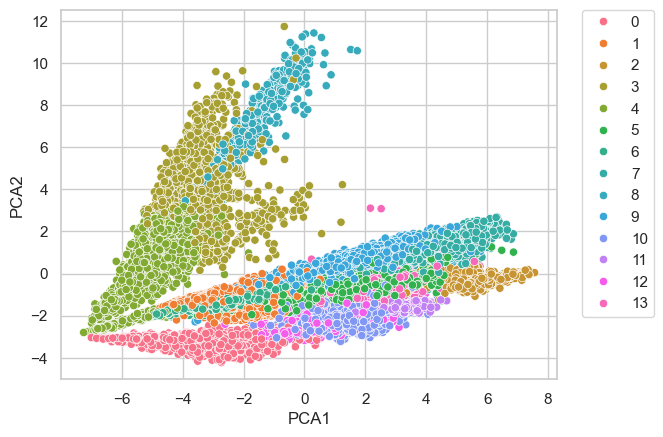

In [111]:
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="h_clusters", data=pca_df, alpha = 1)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Decision Tree Interpretation

In [112]:
clt = DecisionTreeClassifier(max_depth=4, random_state=0).fit(GTEx, part)

In [ ]:
fig = plt.figure(figsize=(30, 10))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=GTEx_data.columns.tolist(),
)

In [113]:
rules = export_text(clt, feature_names=GTEx_data.columns.tolist())
print(rules)

|--- ENSG00000178372.7 <= 0.02
|   |--- ENSG00000162458.12 <= 0.18
|   |   |--- ENSG00000183963.18 <= 0.15
|   |   |   |--- ENSG00000170323.8 <= 0.02
|   |   |   |   |--- class: 4
|   |   |   |--- ENSG00000170323.8 >  0.02
|   |   |   |   |--- class: 5
|   |   |--- ENSG00000183963.18 >  0.15
|   |   |   |--- ENSG00000176658.16 <= 0.07
|   |   |   |   |--- class: 9
|   |   |   |--- ENSG00000176658.16 >  0.07
|   |   |   |   |--- class: 1
|   |--- ENSG00000162458.12 >  0.18
|   |   |--- ENSG00000156642.16 <= 0.24
|   |   |   |--- ENSG00000077420.15 <= 0.01
|   |   |   |   |--- class: 7
|   |   |   |--- ENSG00000077420.15 >  0.01
|   |   |   |   |--- class: 5
|   |   |--- ENSG00000156642.16 >  0.24
|   |   |   |--- ENSG00000186522.14 <= 0.20
|   |   |   |   |--- class: 5
|   |   |   |--- ENSG00000186522.14 >  0.20
|   |   |   |   |--- class: 7
|--- ENSG00000178372.7 >  0.02
|   |--- ENSG00000146648.17 <= 0.14
|   |   |--- ENSG00000186480.12 <= 0.02
|   |   |   |--- class: 6
|   |   |--- E